In [37]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
import shutil
import tensorflow_addons as tfa
import cv2
from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

/home/ilija/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
data = pd.read_csv('./skup/Folds.csv')
img_dir = './skup/BreaKHis_v1/'
class_names = ['benign', 'malignant']

In [5]:
#Renaming the column filename to path
data = data.rename(columns = {"filename":"path"})
#Printing the head of the file
data.head(5)

,fold,mag,grp,path
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [6]:
#Extracting the filename and label from the path column
data['filename'] = data['path'].apply(lambda x:x.split("/")[-1])
data["label"] = data['path'].apply(lambda x: x.split("/")[3])
data.head(5)

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,benign


In [7]:
labels = data['label'].values
labels

array(['benign', 'benign', 'benign', ..., 'malignant', 'malignant',
       'malignant'], dtype=object)

In [8]:
# shutil.rmtree("./Images/")
os.makedirs("./Images/")

In [11]:
#Moving all the images to one folder
for i, p in enumerate(data['path']):
  # if i == 1700: #kad zavrsis ovaj if ukloni
  #   break
  #print(p)
  src = "./skup/BreaKHis_v1/" + p
  dest = "./Images/"
  #saving the files with its corresponding class and patient_id
  #print(src.split("/")[9])
  dest = os.path.join(dest,src.split("/")[6]+ "_" + src.split("/")[-1])
  shutil.copyfile(src,dest)
print("DONE")

KeyboardInterrupt: 

In [12]:
len(os.listdir("./Images/"))

7909

In [13]:
#Creating a new data frame with labels and file names stored in single folder
data['file_loc'] = data['label'] + "_" + data['filename']
#Encoding the class to integer
data['class'] = data['label'].apply(lambda x: 0 if x =='benign' else 1)
data.head(5)

,fold,mag,grp,path,filename,label,file_loc,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign,benign_SOB_B_A-14-22549AB-100-003.png,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,benign,benign_SOB_B_A-14-22549AB-100-004.png,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,benign,benign_SOB_B_A-14-22549AB-100-005.png,0


In [14]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("./Images/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)
df

,label,class
file_loc,,
malignant_SOB_M_MC-14-16456-40-003.png,malignant,1
malignant_SOB_M_DC-14-13993-100-018.png,malignant,1
benign_SOB_B_F-14-29960AB-40-006.png,benign,0
malignant_SOB_M_DC-14-2523-100-043.png,malignant,1
benign_SOB_B_F-14-25197-200-057.png,benign,0
...,...,...
benign_SOB_B_F-14-23222AB-100-011.png,benign,0
malignant_SOB_M_PC-14-12465-100-015.png,malignant,1
benign_SOB_B_F-14-23060AB-100-010.png,benign,0


In [15]:
df.head(5)

,label,class
file_loc,,
malignant_SOB_M_MC-14-16456-40-003.png,malignant,1
malignant_SOB_M_DC-14-13993-100-018.png,malignant,1
benign_SOB_B_F-14-29960AB-40-006.png,benign,0
malignant_SOB_M_DC-14-2523-100-043.png,malignant,1
benign_SOB_B_F-14-25197-200-057.png,benign,0


In [64]:
#Performing the splitting
train, test = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 43, stratify = df["class"] )
#Traing and val
train, val = train_test_split(train, test_size = 0.1, shuffle = True, random_state = 43, stratify = train["class"])

In [65]:
num_samples = min(len(train[train['class'] == 0]), len(train[train['class'] == 1]))
train = pd.concat([train[train['class'] == 0].sample(n=num_samples, random_state=42),
                  train[train['class'] == 1].sample(n=num_samples, random_state=42)])

In [66]:
train

,label,class
file_loc,,
benign_SOB_B_F-14-23222AB-400-011.png,benign,0
benign_SOB_B_A-14-22549CD-400-025.png,benign,0
benign_SOB_B_PT-14-22704-200-012.png,benign,0
benign_SOB_B_TA-14-16184CD-40-004.png,benign,0
benign_SOB_B_F-14-9133-400-016.png,benign,0
...,...,...
malignant_SOB_M_DC-14-12312-100-032.png,malignant,1
malignant_SOB_M_DC-14-5695-400-011.png,malignant,1
malignant_SOB_M_DC-14-9461-400-002.png,malignant,1


In [67]:
test

,label,class
file_loc,,
malignant_SOB_M_DC-14-17614-40-004.png,malignant,1
malignant_SOB_M_DC-14-17901-100-012.png,malignant,1
malignant_SOB_M_DC-14-20629-400-020.png,malignant,1
malignant_SOB_M_DC-14-16716-200-012.png,malignant,1
malignant_SOB_M_DC-14-3909-200-006.png,malignant,1
...,...,...
benign_SOB_B_F-14-14134E-100-015.png,benign,0
malignant_SOB_M_DC-14-16716-100-029.png,malignant,1
malignant_SOB_M_DC-14-5287-100-008.png,malignant,1


In [57]:
sum(test['class'])

496

In [20]:
sum(train['class'])

3908

In [21]:
val

,label,class
file_loc,,
malignant_SOB_M_DC-14-11031-40-008.png,malignant,1
malignant_SOB_M_DC-14-5287-40-022.png,malignant,1
malignant_SOB_M_DC-14-11951-200-028.png,malignant,1
malignant_SOB_M_DC-14-14946-40-029.png,malignant,1
malignant_SOB_M_MC-14-19979-200-017.png,malignant,1
...,...,...
malignant_SOB_M_DC-14-15572-100-003.png,malignant,1
malignant_SOB_M_DC-14-2980-100-001.png,malignant,1
malignant_SOB_M_MC-14-12773-100-025.png,malignant,1


In [23]:
#Creating the directory structure for Training , Validation and Testing because we want to use ImageDataGenerator
os.makedirs("./Images_train")
os.makedirs("./Images_test")
os.makedirs("./Images_validation")
os.makedirs("./Images_train/benign")
os.makedirs("./Images_train/malignant")
os.makedirs("./Images_validation/benign")
os.makedirs("./Images_validation/malignant")
os.makedirs("./Images_test/benign")
os.makedirs("./Images_test/malignant")

FileExistsError: [Errno 17] File exists: './Images_train'

In [24]:
#Training data
for img in train.index:
  target = df.loc[img,'class']
  if target == 1:
      label = 'malignant'
  else:
      label = 'benign'
  src = os.path.join("./Images/",img)
  dest = os.path.join("./Images_train/",label, img)
  shutil.copyfile(src,dest)
print("DONE")

DONE


In [25]:
#Validation data
for img in val.index:
  target = val.loc[img,'class']
  if target == 1:
      label = 'malignant'
  else:
      label = 'benign'

  src = os.path.join("./Images/",img)
  dest = os.path.join("./Images_validation/", label, img)
  shutil.copyfile(src,dest)
print("DONE")

DONE


In [26]:
#Testing data
for img in test.index:
    target = test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'

    src = os.path.join("./Images/",img)
    dest = os.path.join("./Images_test/",label,img)
    shutil.copyfile(src,dest)

In [27]:
#obrisi posle
print("Training Data:")
print("Benign:",len(os.listdir("./Images_train/benign/")))
print("Malignant::",len(os.listdir("./Images_train/malignant/")))
print(" ")
print("Validation Data:")
print("Benign size:",len(os.listdir("./Images_validation/benign/")))
print("Malignant size :",len(os.listdir("./Images_validation/malignant/")))
print(" ")
print("Testing Data:")
print("Benign size :",len(os.listdir("./Images_test/benign/")))
print("Malignant size :",len(os.listdir("./Images_test/malignant/")))

Training Data:
Benign: 1786
Malignant:: 3908
 
Validation Data:
Benign size: 198
Malignant size : 435
 
Testing Data:
Benign size : 496
Malignant size : 1086


In [28]:
batch_size = 128
IMG_SIZE = 128  # Target image size for resizing
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [0.9, 1.1]  # Range for zooming in and out (zoom in by 10%, zoom out by 10%)
BRIGHT_RANGE = [0.7, 1.3]  # Range for adjusting brightness (reduce by 30%, increase by 30%)
HORZ_FLIP = True  # Apply horizontal flipping during augmentation
FILL_MODE = "nearest"  # Fill mode for newly created pixels (nearest-neighbor interpolation)
DATA_FORMAT = "channels_last"  # Data format with color channels as the last dimension

In [68]:
data_generator = ImageDataGenerator(rescale = 1./255,
                                           brightness_range = BRIGHT_RANGE,
                                           zoom_range = 0.1,
                                           rotation_range = 10,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           data_format = "channels_last",
                                           fill_mode = "nearest",
                                           horizontal_flip = True,
                                           vertical_flip=True
                                           )


train_data_gen = data_generator.flow_from_directory(directory = "./Images_train/",
                                                           target_size = DIM,
                                                           batch_size = 64,
                                                           color_mode = 'rgb',
                                                           #shuffle = True,
                                                           class_mode = 'binary'
                                                           )

val_data_gen = data_generator.flow_from_directory(directory = "./Images_validation/",
                                                  target_size = DIM,
                                                  batch_size = 64,
                                                  color_mode = 'rgb',
                                                  class_mode = 'binary'
                                                )

test_data_gen = data_generator.flow_from_directory(directory = "./Images_test/",
                                                   target_size = DIM,
                                                   batch_size = 1,    #proveri da li da stavis veci batch
                                                   shuffle = False,
                                                   class_mode = 'binary'
                                                  )

Found 5694 images belonging to 2 classes.
Found 633 images belonging to 2 classes.
Found 1582 images belonging to 2 classes.


**Helper functions for analyzing model results**






In [30]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def generate_classification_report(model, test_data_gen):
    y_pred = np.round(model.predict(test_data_gen)).astype(int)

    target_names = ['Benign', 'Malignant']
    test_labels = test_data_gen.classes

    report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

    for target_name in target_names:
        precision = report[target_name]['precision']
        recall = report[target_name]['recall']
        f1_score = report[target_name]['f1-score']

        print(f'{target_name} Precision: {precision:.2f}')
        print(f'{target_name} Recall: {recall:.2f}')
        print(f'{target_name} F1 Score: {f1_score:.2f}')
        print()

    avg_precision = report['weighted avg']['precision']
    avg_recall = report['weighted avg']['recall']
    avg_f1_score = report['weighted avg']['f1-score']

    print('Average Precision: {:.2f}'.format(avg_precision * 100))
    print('Average Recall: {:.2f}'.format(avg_recall * 100))
    print('Average F1 Score: {:.2f}'.format(avg_f1_score * 100))

    return avg_precision, avg_recall, avg_f1_score

def plot_roc_curve(model, test_data_gen):
    y_score = model.predict(test_data_gen)

    fpr, tpr, _ = roc_curve(test_data_gen.classes, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(model, test_data_gen):
    y_pred = model.predict(test_data_gen)
    y_pred_binary = (y_pred > 0.5).astype(int)

    confusion = confusion_matrix(test_data_gen.classes, y_pred_binary)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def compare_predictions(model, data_generator, class_names, num_samples=5):

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        x, y_true = next(data_generator)

        y_pred = model.predict(x)

        y_pred = int(np.round(y_pred))
        y_true = int(y_true)

        y_true_name = class_names[y_true]
        y_pred_name = class_names[y_pred]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x[0])
        plt.title(f"Actual: {y_true_name}\n Predicted: {y_pred_name}")
        plt.axis('off')

    plt.show()

***CNN model***

MaxPooling2D sloj u konvolutivnoj neuronskoj mreži (CNN) koristi se za smanjenje dimenzionalnosti izlaza konvolucionih slojeva tako što uzima maksimalnu vrednost iz svakog regiona ili "prozora" ulaza. Ovaj sloj pomaže u smanjenju broja parametara i računarske složenosti, a takođe može pomoći u sprečavanju prenaučenosti.

Evo objašnjenja parametra MaxPooling2D(pool_size=(2, 2)):

pool_size: Ovaj parametar određuje veličinu regiona (prozora) koji će se koristiti za sažimanje. U vašem slučaju, pool_size=(2, 2) znači da će se uzimati maksimalna vrednost iz svakog 2x2 regiona (prozora) ulaznog tenzora. To znači da će se dimenzije izlaza prepoloviti u svakoj dimenziji (širina i visina) u odnosu na ulaz.
Na primer, ako imate ulazni tenzor dimenzija 4x4, primena MaxPooling2D(pool_size=(2, 2)) će rezultirati izlaznim tenzorom dimenzija 2x2, gde se uzima maksimalna vrednost iz svakog 2x2 regiona ulaza.

Ovo sažimanje pomaže u očuvanju najvažnijih karakteristika iz ulaza dok smanjuje dimenzionalnost, čime se smanjuje računarska složenost i pomaže u kontroli prenaučenosti u modelu.

 Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same')
1. Svaki filter je odgovoran za detekciju različitih karakteristika ili oblika u ulaznoj slici. U ovom slučaju, koristit ćete 16 filtera.
2. Označava veličinu filtera. Filteri se koriste za skeniranje ulazne slike region po region, a ovaj broj određuje dimenzije filtera. U ovom slučaju, filteri će biti 3x3 piksela.
3. Oznacava aktivacionu funkciju
4. Parametar padding određuje kako će se obraditi ivice slike. Postavljanje na 'same' znači da će se dodati nula vrednosti oko slike tako da izlazni sloj ima iste dimenzije kao i ulazna slika.

Regularizacija izostavljanjem (eng. dropout) je tehnika regularizacije kojom se može poboljšati stabilnost optimizacije odnosno obučavanje neuronske mreže. Dropout se definiše nad slojem tako što se zada parametar između 0 i 1. Ako postavimo da je dropout 0.1, tokom treninga će u tom sloju nasumično biti odabrano 10% jedinica kojima će biti ubijem izlaz. Ovime povećavamo robusnost modela jer ga teramo da se tokom treninga više adaptira na ove promene koje dropout uvodi.
Smanjuje overfittovanje.

In [31]:
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size=2),
    Dropout(0.5),

    Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [73]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# @title Default title text
epochs = 50 #50 stavi kasnije
# Parametar `patience` je broj epoha koji se razmatra za zaustavljanje.
# Parametar `monitor` predstavlja meru koja se poredi kroz epohe.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint("./Best_model/", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#history = model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs,callbacks=[early_stop, checkpoint], verbose=1)

In [45]:
cnn_history = history

cnn_accuracy_history = cnn_history.history['accuracy']
cnn_loss_history = cnn_history.history['loss']

In [42]:
cnn_model = model
loss, accuracy= cnn_model.evaluate(test_data_gen)


1582/1582 [==============================] - 27s 17ms/step - loss: 0.3202 - accuracy: 0.8767


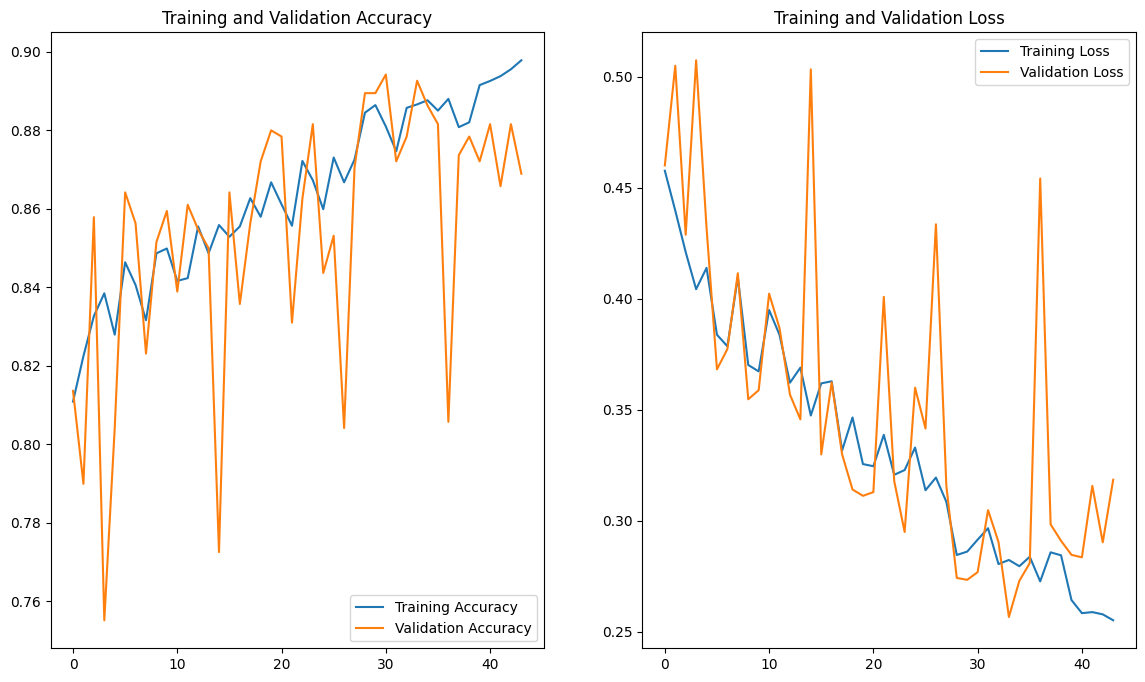

In [43]:
plot_training_history(cnn_history)

In [46]:
cnn_precision, cnn_recall, cnn_f1_score = generate_classification_report(cnn_model, test_data_gen)

1582/1582 [==============================] - 26s 16ms/step
Benign Precision: 0.93
Benign Recall: 0.65
Benign F1 Score: 0.76

Malignant Precision: 0.86
Malignant Recall: 0.98
Malignant F1 Score: 0.91

Average Precision: 88.20
Average Recall: 87.48
Average F1 Score: 86.76


1582/1582 [==============================] - 25s 16ms/step


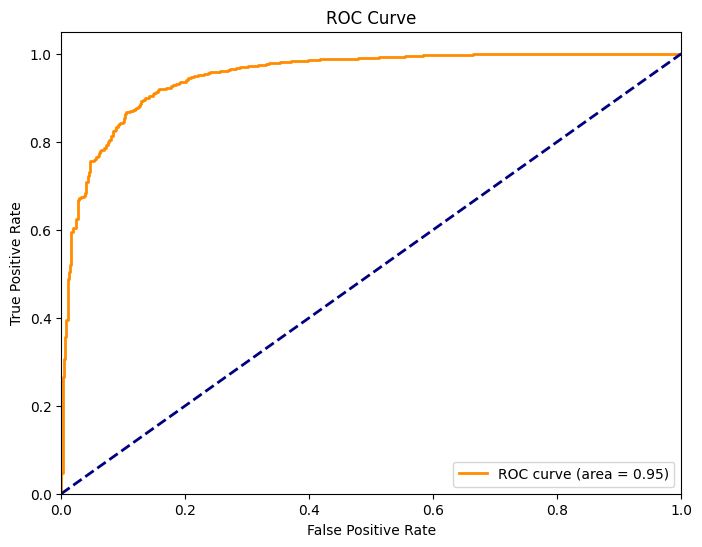

In [47]:
plot_roc_curve(cnn_model, test_data_gen)

1582/1582 [==============================] - 25s 16ms/step


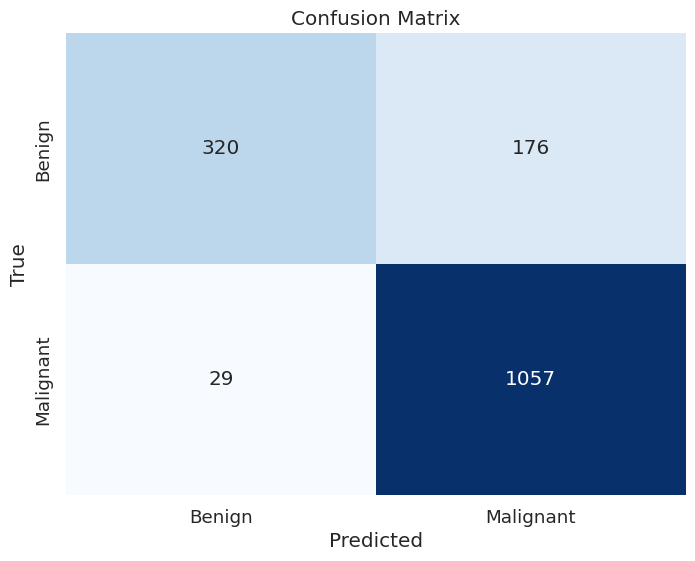

In [48]:
plot_confusion_matrix(cnn_model, test_data_gen)

1/1 [==============================] - 0s 18ms/step


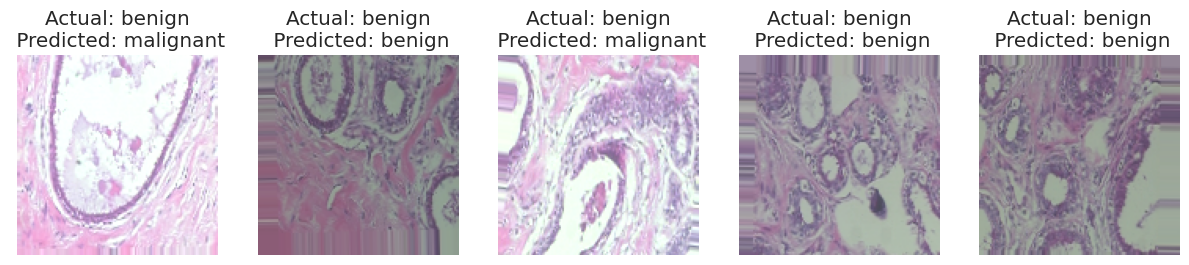

In [49]:
compare_predictions(cnn_model, test_data_gen, class_names, num_samples=5)

***VGG16 model***

In [74]:
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_base_model.trainable = False

vgg_model=Sequential()
vgg_model.add(vgg_base_model)
vgg_model.add(Dropout(0.5))
vgg_model.add(Flatten())
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(512,activation='relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(128,activation='relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1,activation='sigmoid'))

In [75]:
vgg_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
checkpoint = ModelCheckpoint("./Best_vgg_model/", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
vgg_history = vgg_model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs,callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.6661
Epoch 1: val_loss improved from inf to 0.50374, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 531s 6s/step - loss: 0.7189 - accuracy: 0.6661 - val_loss: 0.5037 - val_accuracy: 0.7472
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7380
Epoch 2: val_loss improved from 0.50374 to 0.47348, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 558s 6s/step - loss: 0.5697 - accuracy: 0.7380 - val_loss: 0.4735 - val_accuracy: 0.7867
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7615
Epoch 3: val_loss improved from 0.47348 to 0.42806, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 533s 6s/step - loss: 0.5073 - accuracy: 0.7615 - val_loss: 0.4281 - val_accuracy: 0.8057
Epoch 4/50
89/89 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7810
Epoch 4: val_loss improved from 0.42806 to 0.40170, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 547s 6s/step - loss: 0.4787 - accuracy: 0.7810 - val_loss: 0.4017 - val_accuracy: 0.8136
Epoch 5/50
89/89 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.7798
Epoch 5: val_loss did not improve from 0.40170
89/89 [==============================] - 535s 6s/step - loss: 0.4793 - accuracy: 0.7798 - val_loss: 0.4073 - val_accuracy: 0.8262
Epoch 6/50
89/89 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.7954
Epoch 6: val_loss improved from 0.40170 to 0.40103, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 546s 6s/step - loss: 0.4433 - accuracy: 0.7954 - val_loss: 0.4010 - val_accuracy: 0.8104
Epoch 7/50
89/89 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.8100
Epoch 7: val_loss did not improve from 0.40103
89/89 [==============================] - 538s 6s/step - loss: 0.4259 - accuracy: 0.8100 - val_loss: 0.4019 - val_accuracy: 0.8120
Epoch 8/50
89/89 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8119
Epoch 8: val_loss improved from 0.40103 to 0.39985, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 538s 6s/step - loss: 0.4215 - accuracy: 0.8119 - val_loss: 0.3999 - val_accuracy: 0.8152
Epoch 9/50
89/89 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8121
Epoch 9: val_loss improved from 0.39985 to 0.39036, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 546s 6s/step - loss: 0.4149 - accuracy: 0.8121 - val_loss: 0.3904 - val_accuracy: 0.8357
Epoch 10/50
89/89 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8174
Epoch 10: val_loss improved from 0.39036 to 0.38362, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 542s 6s/step - loss: 0.4182 - accuracy: 0.8174 - val_loss: 0.3836 - val_accuracy: 0.8294
Epoch 11/50
89/89 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8112
Epoch 11: val_loss improved from 0.38362 to 0.37252, saving model to ./Best_vgg_model/
INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_model/assets


89/89 [==============================] - 536s 6s/step - loss: 0.4132 - accuracy: 0.8112 - val_loss: 0.3725 - val_accuracy: 0.8341
Epoch 12/50
89/89 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8189
Epoch 12: val_loss did not improve from 0.37252
89/89 [==============================] - 534s 6s/step - loss: 0.4048 - accuracy: 0.8189 - val_loss: 0.3803 - val_accuracy: 0.8499
Epoch 13/50
89/89 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8196
Epoch 13: val_loss did not improve from 0.37252
89/89 [==============================] - 544s 6s/step - loss: 0.4073 - accuracy: 0.8196 - val_loss: 0.3885 - val_accuracy: 0.8231
Epoch 14/50
89/89 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8247
Epoch 14: val_loss did not improve from 0.37252
89/89 [==============================] - 546s 6s/step - loss: 0.4003 - accuracy: 0.8247 - val_loss: 0.3841 - val_accuracy: 0.8246
Epoch 15/50
89/89 [==============================] 

In [77]:
vgg_accuracy_history = vgg_history.history['accuracy']
vgg_loss_history = vgg_history.history['loss']

In [80]:
loss, accuracy= vgg_model.evaluate(test_data_gen)

1582/1582 [==============================] - 136s 86ms/step - loss: 0.3652 - accuracy: 0.8439


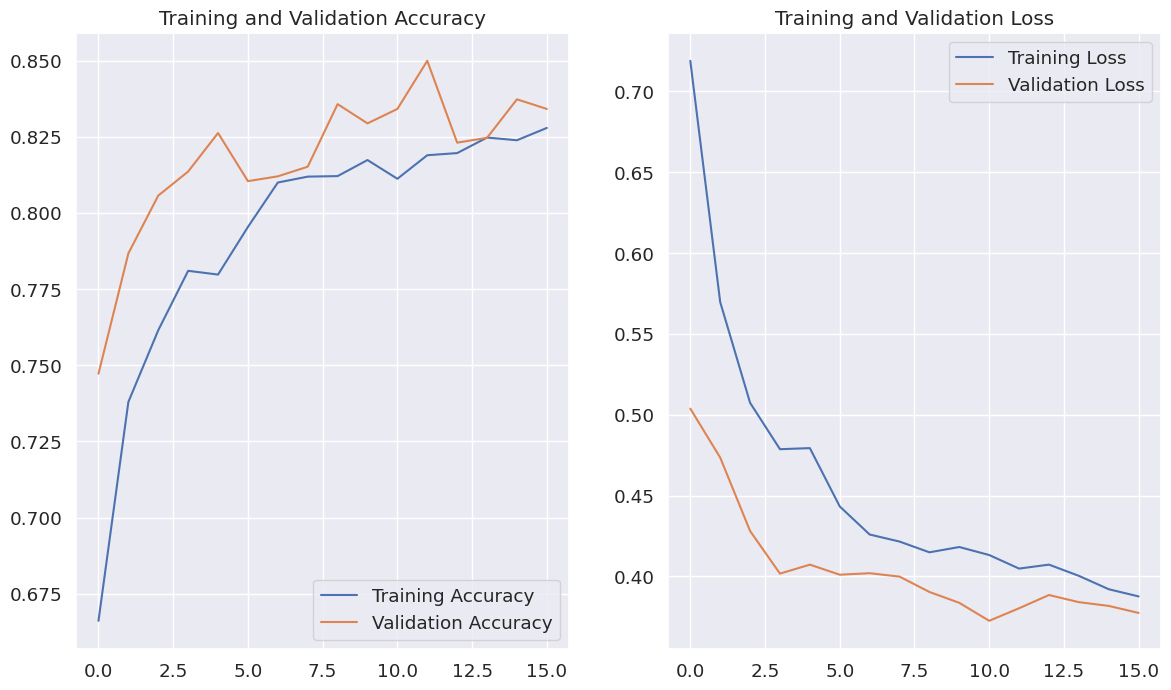

In [81]:
plot_training_history(vgg_history)

In [82]:
vgg_precision, vgg_recall, vgg_f1_score = generate_classification_report(vgg_model, test_data_gen)

1582/1582 [==============================] - 138s 87ms/step
Benign Precision: 0.77
Benign Recall: 0.71
Benign F1 Score: 0.74

Malignant Precision: 0.87
Malignant Recall: 0.91
Malignant F1 Score: 0.89

Average Precision: 84.06
Average Recall: 84.32
Average F1 Score: 84.12


1582/1582 [==============================] - 134s 85ms/step


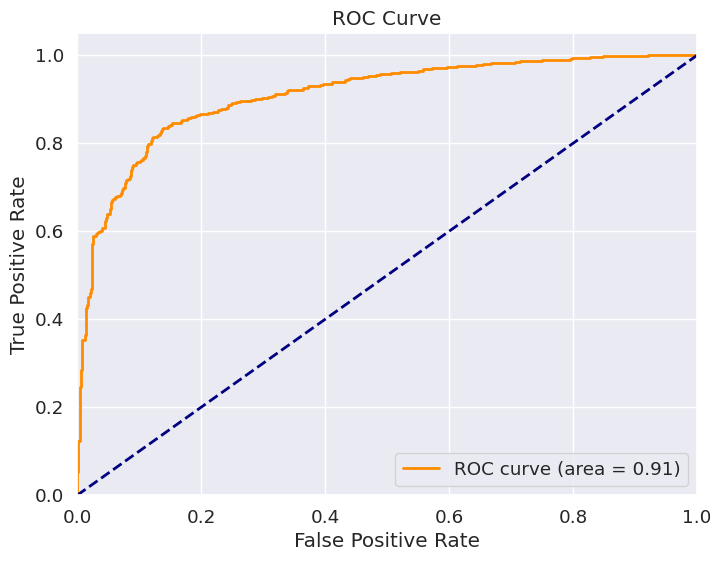

In [83]:
plot_roc_curve(vgg_model, test_data_gen)

1582/1582 [==============================] - 136s 86ms/step


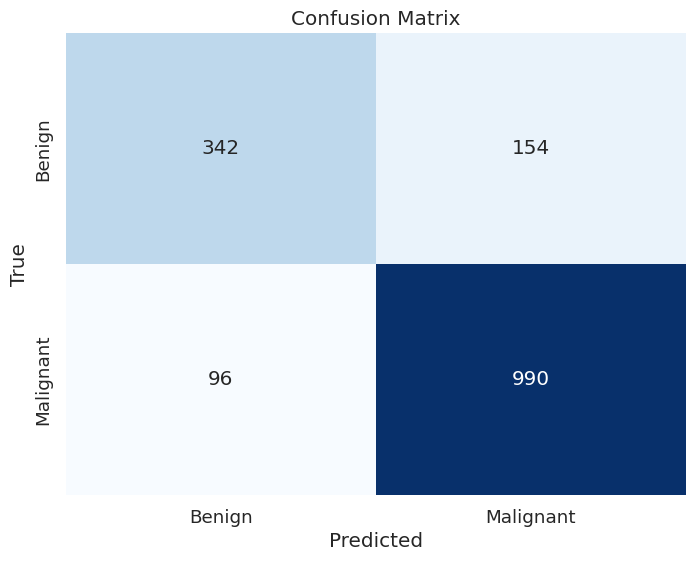

In [84]:
plot_confusion_matrix(vgg_model, test_data_gen)

1/1 [==============================] - 0s 80ms/step


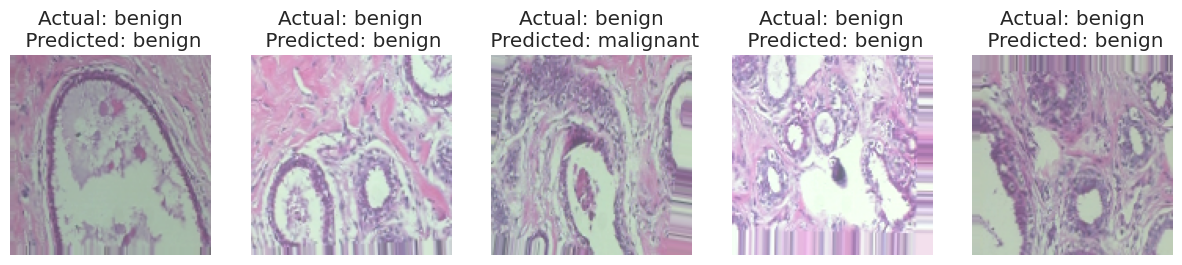

In [85]:
compare_predictions(vgg_model, test_data_gen, class_names, num_samples=5)

**VGG16 - pure model**

In [86]:
vgg_pure_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_pure_base_model.trainable = True

vgg_pure_model=Sequential()
vgg_pure_model.add(vgg_base_model)
vgg_pure_model.add(Dropout(0.5))
vgg_pure_model.add(Flatten())
vgg_pure_model.add(BatchNormalization())
vgg_pure_model.add(Dense(512,activation='relu'))
vgg_pure_model.add(BatchNormalization())
vgg_pure_model.add(Dropout(0.5))
vgg_pure_model.add(Dense(128,activation='relu'))
vgg_pure_model.add(BatchNormalization())
vgg_pure_model.add(Dropout(0.5))
vgg_pure_model.add(Dense(1,activation='sigmoid'))

In [87]:
vgg_pure_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [88]:
checkpoint = ModelCheckpoint("./Best_vgg_pure_model/", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
vgg_pure_history = vgg_pure_model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs,callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.6637
Epoch 1: val_loss improved from inf to 0.49479, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 500s 6s/step - loss: 0.7239 - accuracy: 0.6637 - val_loss: 0.4948 - val_accuracy: 0.7662
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.7438
Epoch 2: val_loss improved from 0.49479 to 0.46178, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 507s 6s/step - loss: 0.5609 - accuracy: 0.7438 - val_loss: 0.4618 - val_accuracy: 0.7788
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7613
Epoch 3: val_loss improved from 0.46178 to 0.43729, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 505s 6s/step - loss: 0.5236 - accuracy: 0.7613 - val_loss: 0.4373 - val_accuracy: 0.7962
Epoch 4/50
89/89 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7731
Epoch 4: val_loss improved from 0.43729 to 0.43261, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 512s 6s/step - loss: 0.4843 - accuracy: 0.7731 - val_loss: 0.4326 - val_accuracy: 0.7994
Epoch 5/50
89/89 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.7877
Epoch 5: val_loss improved from 0.43261 to 0.42144, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 517s 6s/step - loss: 0.4655 - accuracy: 0.7877 - val_loss: 0.4214 - val_accuracy: 0.8041
Epoch 6/50
89/89 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7952
Epoch 6: val_loss did not improve from 0.42144
89/89 [==============================] - 520s 6s/step - loss: 0.4475 - accuracy: 0.7952 - val_loss: 0.4260 - val_accuracy: 0.8088
Epoch 7/50
89/89 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8068
Epoch 7: val_loss improved from 0.42144 to 0.41476, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 525s 6s/step - loss: 0.4318 - accuracy: 0.8068 - val_loss: 0.4148 - val_accuracy: 0.7867
Epoch 8/50
89/89 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8121
Epoch 8: val_loss did not improve from 0.41476
89/89 [==============================] - 513s 6s/step - loss: 0.4132 - accuracy: 0.8121 - val_loss: 0.4308 - val_accuracy: 0.7773
Epoch 9/50
89/89 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8096
Epoch 9: val_loss improved from 0.41476 to 0.39911, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 750s 8s/step - loss: 0.4240 - accuracy: 0.8096 - val_loss: 0.3991 - val_accuracy: 0.8262
Epoch 10/50
89/89 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8214
Epoch 10: val_loss did not improve from 0.39911
89/89 [==============================] - 534s 6s/step - loss: 0.4054 - accuracy: 0.8214 - val_loss: 0.4021 - val_accuracy: 0.8294
Epoch 11/50
89/89 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8124
Epoch 11: val_loss improved from 0.39911 to 0.38540, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 529s 6s/step - loss: 0.4127 - accuracy: 0.8124 - val_loss: 0.3854 - val_accuracy: 0.8246
Epoch 12/50
89/89 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8214
Epoch 12: val_loss did not improve from 0.38540
89/89 [==============================] - 525s 6s/step - loss: 0.3998 - accuracy: 0.8214 - val_loss: 0.3975 - val_accuracy: 0.8373
Epoch 13/50
89/89 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8298
Epoch 13: val_loss improved from 0.38540 to 0.37340, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 528s 6s/step - loss: 0.3877 - accuracy: 0.8298 - val_loss: 0.3734 - val_accuracy: 0.8152
Epoch 14/50
89/89 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8219
Epoch 14: val_loss did not improve from 0.37340
89/89 [==============================] - 534s 6s/step - loss: 0.3927 - accuracy: 0.8219 - val_loss: 0.3735 - val_accuracy: 0.8310
Epoch 15/50
89/89 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8217
Epoch 15: val_loss improved from 0.37340 to 0.37295, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 520s 6s/step - loss: 0.3941 - accuracy: 0.8217 - val_loss: 0.3729 - val_accuracy: 0.8357
Epoch 16/50
89/89 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8288
Epoch 16: val_loss did not improve from 0.37295
89/89 [==============================] - 534s 6s/step - loss: 0.3891 - accuracy: 0.8288 - val_loss: 0.3868 - val_accuracy: 0.8436
Epoch 17/50
89/89 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8253
Epoch 17: val_loss did not improve from 0.37295
89/89 [==============================] - 523s 6s/step - loss: 0.3845 - accuracy: 0.8253 - val_loss: 0.3888 - val_accuracy: 0.8215
Epoch 18/50
89/89 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8318
Epoch 18: val_loss did not improve from 0.37295
89/89 [==============================] - 516s 6s/step - loss: 0.3755 - accuracy: 0.8318 - val_loss: 0.3893 - val_accuracy: 0.8278
Epoch 19/50
89/89 [==============================] 

INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 519s 6s/step - loss: 0.3780 - accuracy: 0.8330 - val_loss: 0.3689 - val_accuracy: 0.8468
Epoch 20/50
89/89 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8332
Epoch 20: val_loss improved from 0.36895 to 0.36342, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 525s 6s/step - loss: 0.3743 - accuracy: 0.8332 - val_loss: 0.3634 - val_accuracy: 0.8578
Epoch 21/50
89/89 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8316
Epoch 21: val_loss did not improve from 0.36342
89/89 [==============================] - 519s 6s/step - loss: 0.3725 - accuracy: 0.8316 - val_loss: 0.3773 - val_accuracy: 0.8420
Epoch 22/50
89/89 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8298
Epoch 22: val_loss improved from 0.36342 to 0.35455, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 517s 6s/step - loss: 0.3779 - accuracy: 0.8298 - val_loss: 0.3546 - val_accuracy: 0.8310
Epoch 23/50
89/89 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8393
Epoch 23: val_loss improved from 0.35455 to 0.34219, saving model to ./Best_vgg_pure_model/
INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


INFO:tensorflow:Assets written to: ./Best_vgg_pure_model/assets


89/89 [==============================] - 531s 6s/step - loss: 0.3641 - accuracy: 0.8393 - val_loss: 0.3422 - val_accuracy: 0.8420
Epoch 24/50
89/89 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8368
Epoch 24: val_loss did not improve from 0.34219
89/89 [==============================] - 663s 7s/step - loss: 0.3654 - accuracy: 0.8368 - val_loss: 0.4069 - val_accuracy: 0.8088
Epoch 25/50
89/89 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8400
Epoch 25: val_loss did not improve from 0.34219
89/89 [==============================] - 521s 6s/step - loss: 0.3625 - accuracy: 0.8400 - val_loss: 0.3627 - val_accuracy: 0.8436
Epoch 26/50
89/89 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8377
Epoch 26: val_loss did not improve from 0.34219
89/89 [==============================] - 517s 6s/step - loss: 0.3669 - accuracy: 0.8377 - val_loss: 0.3700 - val_accuracy: 0.8341
Epoch 27/50
89/89 [==============================] 

In [89]:
vgg_pure_accuracy_history = vgg_pure_history.history['accuracy']
vgg_pure_loss_history = vgg_pure_history.history['loss']

In [90]:
loss, accuracy= vgg_pure_model.evaluate(test_data_gen)

1582/1582 [==============================] - 133s 84ms/step - loss: 0.3406 - accuracy: 0.8451


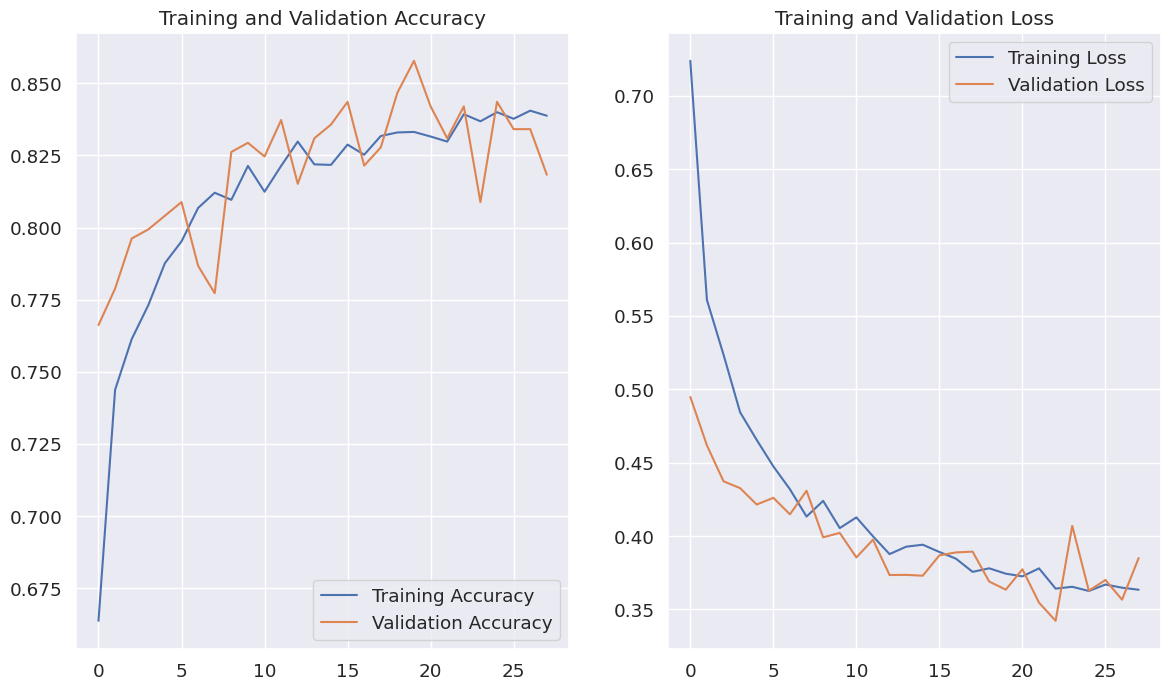

In [91]:
plot_training_history(vgg_pure_history)

In [92]:
vgg_pure_precision, vgg_pure_recall, vgg_pure_f1_score = generate_classification_report(vgg_pure_model, test_data_gen)

1582/1582 [==============================] - 138s 87ms/step
Benign Precision: 0.79
Benign Recall: 0.68
Benign F1 Score: 0.73

Malignant Precision: 0.86
Malignant Recall: 0.92
Malignant F1 Score: 0.89

Average Precision: 83.87
Average Recall: 84.20
Average F1 Score: 83.84


1582/1582 [==============================] - 137s 87ms/step


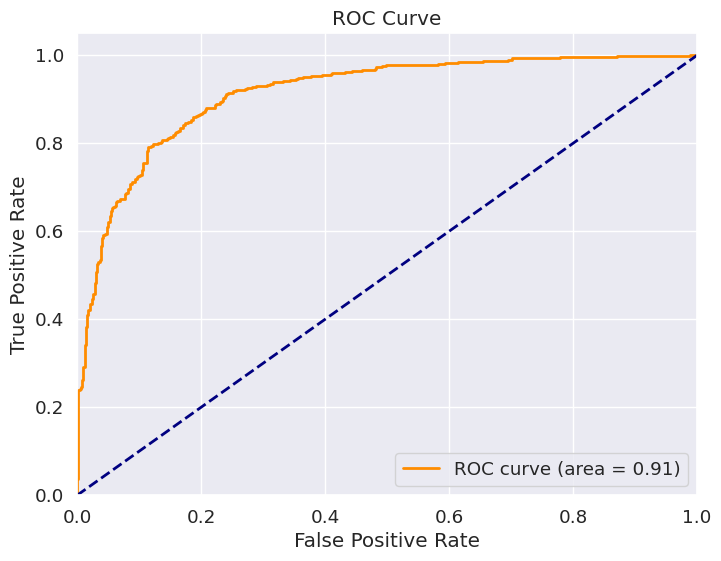

In [93]:
plot_roc_curve(vgg_pure_model, test_data_gen)

1582/1582 [==============================] - 130s 82ms/step


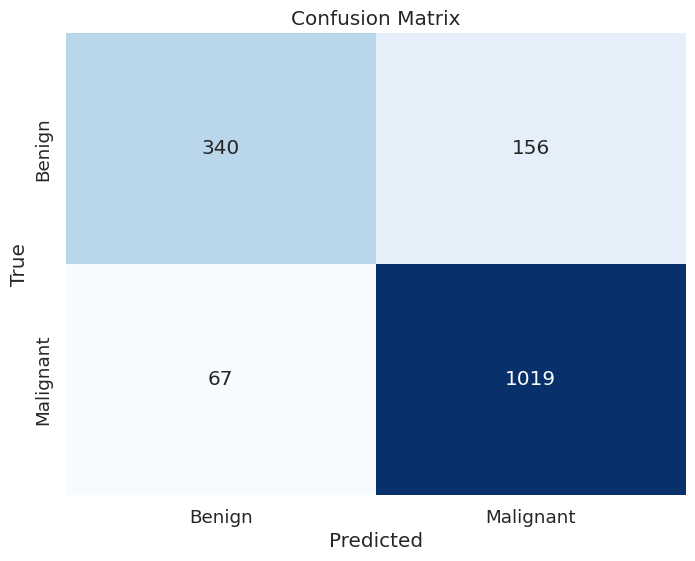

In [94]:
plot_confusion_matrix(vgg_pure_model, test_data_gen)

1/1 [==============================] - 0s 78ms/step


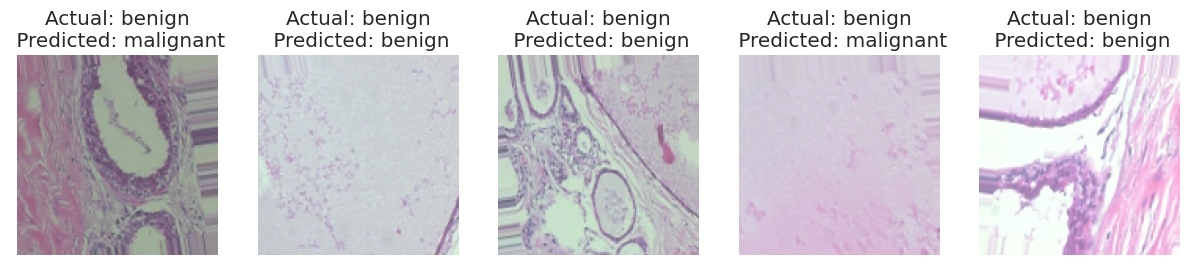

In [95]:
compare_predictions(vgg_pure_model, test_data_gen, class_names, num_samples=5)

In [96]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_data_gen)
vgg_loss, vgg_accuracy = vgg_model.evaluate(test_data_gen)
vgg_pure_loss, vgg_pure_accuracy = vgg_pure_model.evaluate(test_data_gen)

1582/1582 [==============================] - 138s 87ms/step - loss: 0.3446 - accuracy: 0.8401


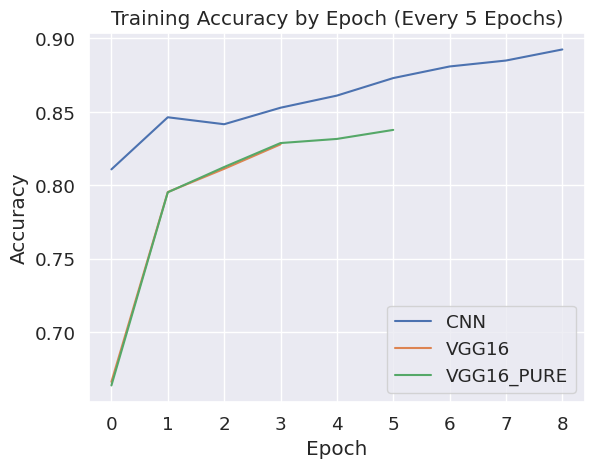

In [97]:
# Extract the accuracy history for each model every 5 epochs
cnn_history = cnn_accuracy_history[::5]
vgg_history = vgg_accuracy_history[::5]
vgg_pure_history = vgg_pure_accuracy_history[::5]

plt.plot(cnn_history, label='CNN')
plt.plot(vgg_history, label='VGG16')
plt.plot(vgg_pure_history, label='VGG16_PURE')

plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

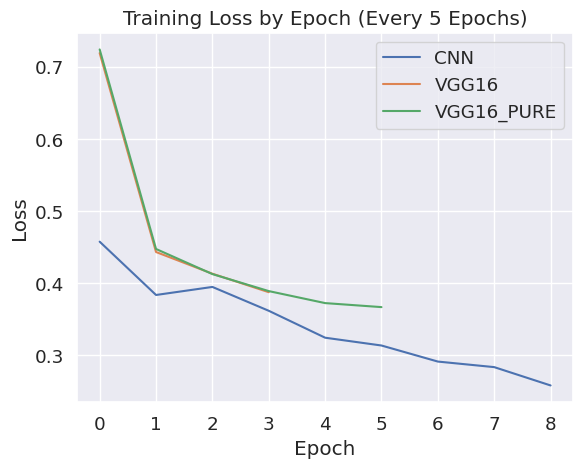

In [98]:
# Extract the loss history for each model every 5 epochs
cnn_history = cnn_loss_history[::5]
vgg_history = vgg_loss_history[::5]
vgg_pure_history = vgg_pure_loss_history[::5]

# Plot the loss history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg_history, label='VGG16')
plt.plot(vgg_pure_history, label='VGG16_PURE')

# Set the plot title and axis labels
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [99]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Model': ['CNN', 'VGG16', 'VGG16_PURE'],
    'Avg Precision': [cnn_precision*100, vgg_precision*100, vgg_pure_precision*100],
    'Avg Recall': [cnn_recall*100, vgg_recall*100, vgg_pure_recall*100],
    'Avg F1-Score': [cnn_f1_score*100, vgg_f1_score*100, vgg_pure_f1_score*100]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the DataFrame
print(metrics_df)

        Model  Avg Precision  Avg Recall  Avg F1-Score
0         CNN      88.199967   87.484197     86.761110
1       VGG16      84.055357   84.323641     84.115475
2  VGG16_PURE      83.874832   84.197219     83.844028
